In [285]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [114]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [115]:
# Run a DMRG calculation (i.e. a single-state subspace):

dmrg1 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));

dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt)]

GenStates!(dmrg1, verbose=true);

GenPermOps!(dmrg1)

GenSubspaceMats!(dmrg1, verbose=true)

println("DMRG energy: ", dmrg1.H_mat[1,1] + dmrg1.chem_data.e_nuc)

dens = expect(dmrg1.psi_list[1],"Ntot")
println("Expected particle number: ", dmrg1.chem_data.N_el)
println("Particle number: ", sum(dens))

Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.01518748485249
Expected particle number: 10
Particle number: 10.000000000000002


In [116]:
bipartitions, entropies = ComputeBipartites(dmrg1, ns=40)

println(length(bipartitions))

63


In [117]:
dmrg2 = copy(dmrg1);

#Profile.clear()

init_ord = randperm(dmrg2.chem_data.N_spt)
println(init_ord)

dmrg2.ord_list = BipartiteAnnealing(
    [init_ord], 
    bipartitions, 
    entropies, 
    dmrg2.mparams.psi_maxdim,
    maxiter=4000, 
    swap_mult=2.0, 
    alpha=1e-4, 
    stun=true, 
    gamma=1e4, 
    zeta=0.1,
    xi=0.3,
    verbose=true
);

println("\n$(dmrg2.ord_list[1])")

[6, 7, 4, 2, 3, 5, 1]
0.33206317054549106    
[7, 3, 6, 4, 2, 1, 5]


In [118]:
GenStates!(dmrg2, verbose=true);

GenPermOps!(dmrg2)

GenSubspaceMats!(dmrg2, verbose=true)

println("DMRG energy: ", dmrg2.H_mat[1,1] + dmrg2.chem_data.e_nuc)

dens = expect(dmrg2.psi_list[1],"Ntot")
println("Expected particle number: ", dmrg2.chem_data.N_el)
println("Particle number: ", sum(dens))

Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.01887487559803
Expected particle number: 10
Particle number: 9.999999999999996


In [381]:
tnqe2 = GenSubspace(chemical_data, 6, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-6));

tnqe2.ord_list = [dmrg2.ord_list[1]]

for k=1:tnqe2.mparams.M-1
    
    tnqe2.ord_list = vcat(tnqe2.ord_list, [randperm(tnqe2.chem_data.N_spt)])
    
    tnqe2.ord_list, statevec = BipartiteAnnealing(
        tnqe2.ord_list, 
        bipartitions, 
        entropies, 
        tnqe2.mparams.psi_maxdim,
        anchor=true,
        anum=k,
        maxiter=1000, 
        swap_mult=0.5, 
        alpha=1e-5, 
        stun=true, 
        gamma=1e4, 
        zeta=0.1,
        xi=0.3,
        opt_statevec=true,
        delta=1e-8,
        verbose=true
    );
    
    println("")
    
end

tnqe2.ord_list, statevec = BipartiteAnnealing(
        tnqe2.ord_list, 
        bipartitions, 
        entropies, 
        tnqe2.mparams.psi_maxdim,
        anchor=true,
        anum=1,
        maxiter=1000, 
        swap_mult=0.5, 
        alpha=1e-5, 
        stun=true, 
        gamma=1e4, 
        zeta=0.1,
        xi=0.3,
        opt_statevec=true,
        delta=1e-8,
        verbose=true
    );


0.3701301601727365     
0.2647767797595148     
0.20057616339393924    
0.1493133497547413     
0.11359624735797547    


In [382]:
GenPermOps!(tnqe2, verbose=true)

Generating permutation operators:
Progress: [15/15] 
Done!



In [383]:
# Solve GenEig to rank in terms of importance:
opt_sweeps = Sweeps(15)
maxdim!(opt_sweeps,tnqe2.mparams.psi_maxdim)
mindim!(opt_sweeps,tnqe2.mparams.psi_maxdim)
cutoff!(opt_sweeps,1e-12)
setnoise!(opt_sweeps, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

"""
GenStates!(tnqe2, sweeps=opt_sweeps, verbose=true);

GenSubspaceMats!(tnqe2, verbose=true)

SolveGenEig!(tnqe2, thresh="inversion", eps=1e-8, verbose=true)
"""

"GenStates!(tnqe2, sweeps=opt_sweeps, verbose=true);\n\nGenSubspaceMats!(tnqe2, verbose=true)\n\nSolveGenEig!(tnqe2, thresh=\"inversion\", eps=1e-8, verbose=true)\n"

Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [2/2] 
Done!
Generating states:
Progress: [3/3] 
Done!
Generating states:
Progress: [4/4] 
Done!
Generating states:
Progress: [5/5] 
Done!
Generating states:
Progress: [6/6] 
Done!
Minimum eigenvalue: -83.83223755149686
Condition number: 10283.749971917807
FCI energy: -75.01927599660624
Final energy estimate: -74.99121738248594
Best single ref. estimate: -74.99121494963393
Error: 0.02805861412029742
BSRfE: 0.028061046972311487
Improvement: 2.432852014067066e-6
Percentage error reduction: 0.008669854750849531
Eigenvalue condition numbers: [0.0119, 0.012, 0.012, 0.0121, 0.0122, 0.0122]
Percent correlation energy with single-geometry DMRG: 51.706195348312455
Percent correlation energy with multi-geometry TNQE: 51.710382351029416


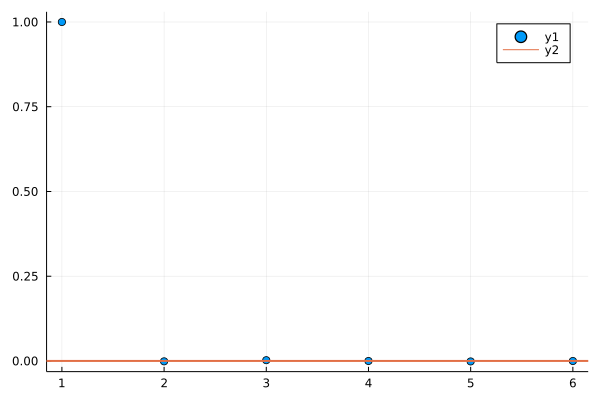

In [398]:
tnqe3 = copy(tnqe2)

GenExcited!(tnqe3, sweeps=opt_sweeps, weight = 2.0, lev=4, verbose=true)

GenSubspaceMats!(tnqe3, verbose=true)

SolveGenEig!(tnqe3, thresh="inversion", eps=1e-8, verbose=true)

In [399]:
"""
# Coarse optimization:
println("COARSE OPTIMIZATION:")
println("")
for l=1:4
    for k=1:3
        
        MultiGeomOptim!(
            tnqe3, 
            sweeps=6, 
            method="geneig",
            noise=[10.0^(-k)],
            thresh="inversion",
            eps=1e-6,
            restrict_svals=false,
            verbose=true
        )

        println("")
        MultiGeomOptim!(
            tnqe3, 
            sweeps=4, 
            method="geneig",
            noise=[0.0],
            thresh="inversion",
            eps=1e-6,
            restrict_svals=true,
            verbose=true
        )

        println("")

    end
end
"""

println("")
println("FINE OPTIMIZATION:")
println("")


# Fine optimization:
for k=1:9
    
    MultiGeomOptim!(
        tnqe3, 
        sweeps=6, 
        method="annealing",
        noise=[10.0^(-k),10.0^(-k),10.0^(-k),10.0^(-k),10.0^(-k),10.0^(-k)],
        thresh="inversion",
        eps=1e-6,
        restrict_svals=false,
        verbose=true
    )

    println("")
    
    MultiGeomOptim!(
        tnqe3, 
        sweeps=4, 
        method="annealing",
        noise=[10.0^(-k)],
        thresh="inversion",
        eps=1e-6,
        restrict_svals=true,
        verbose=true
    )
    
    println("")
    
end

println("")
println("FINISHING TOUCHES:")
println("")

# Finishing touches:
MultiGeomOptim!(
        tnqe3, 
        sweeps=4, 
        method="geneig",
        noise=[10.0^(-8),10.0^(-10),0.0,0.0],
        thresh="inversion",
        eps=1e-6,
        restrict_svals=true,
        verbose=true
    )


FINE OPTIMIZATION:

Sweep: [6/6]; site: [6/6]; E_min = -83.83900826869939; kappa = 7.320623875353924              
Sweep: [4/4]; site: [6/6]; E_min = -83.83717109334448; kappa = 8.68355670906633               
Sweep: [6/6]; site: [6/6]; E_min = -83.83731943867039; kappa = 13.628054068579912             
Sweep: [4/4]; site: [6/6]; E_min = -83.83811991714352; kappa = 12.001140042918635             
Sweep: [6/6]; site: [6/6]; E_min = -83.83931504107814; kappa = 10.01363981604729              
Sweep: [4/4]; site: [6/6]; E_min = -83.8408704492867; kappa = 13.16173358570844               
Sweep: [6/6]; site: [6/6]; E_min = -83.8421918554013; kappa = 13.288315073650583              
Sweep: [4/4]; site: [6/6]; E_min = -83.84214119106491; kappa = 7.961359710887704              


LoadError: InterruptException:

Minimum eigenvalue: -83.84215441579501
Condition number: 7.318718407472353
FCI energy: -75.01927599660624
Final energy estimate: -75.00113424678409
Best single ref. estimate: -74.71908350735018
Error: 0.018141749822149222
BSRfE: 0.30019248925606234
Improvement: 0.2820507394339131
Percentage error reduction: 93.95662767342776
Eigenvalue condition numbers: [0.0119, 0.012, 0.0121, 0.0121, 0.0121, 0.0122]
Percent correlation energy with single-geometry DMRG: -416.6392204945546
Percent correlation energy with multi-geometry TNQE: 68.77756832041354


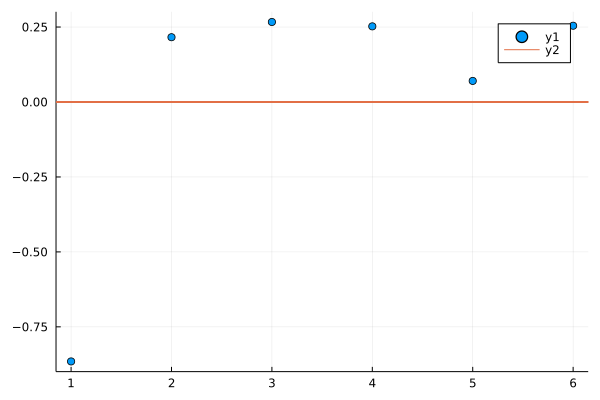

In [400]:
GenSubspaceMats!(tnqe3, verbose=true)

SolveGenEig!(tnqe3, thresh="inversion", verbose=true)

In [401]:
for j=1:tnqe3.mparams.M
    println(BipartiteFitness([tnqe3.ord_list[j]], bipartitions, entropies, tnqe3.mparams.psi_maxdim; zeta=0.1, xi=0.3))
end

0.5591038337365365
0.5591038337365364
0.566618072576478
0.5646871526756355
0.5631286668171797
0.5763314702564165


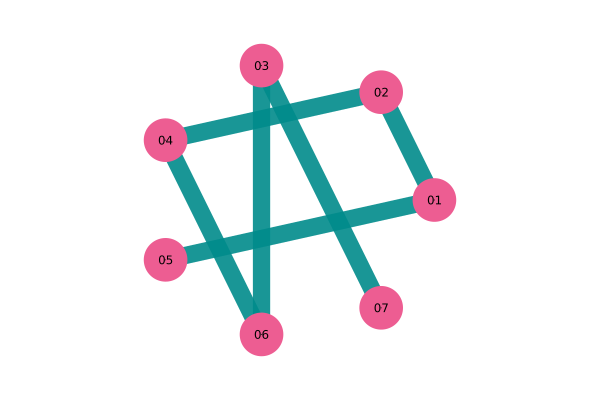

Weight: 0.8653355044425529


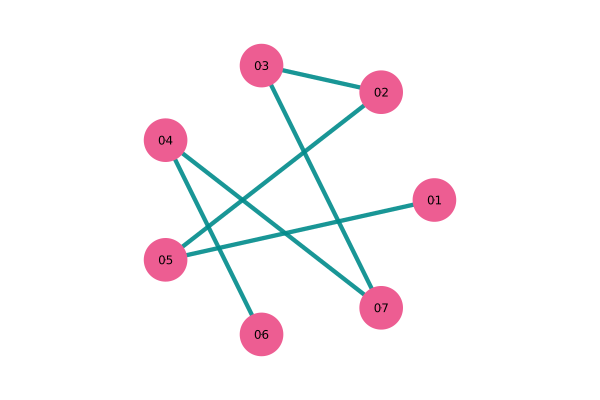

Weight: 0.21605836589851043


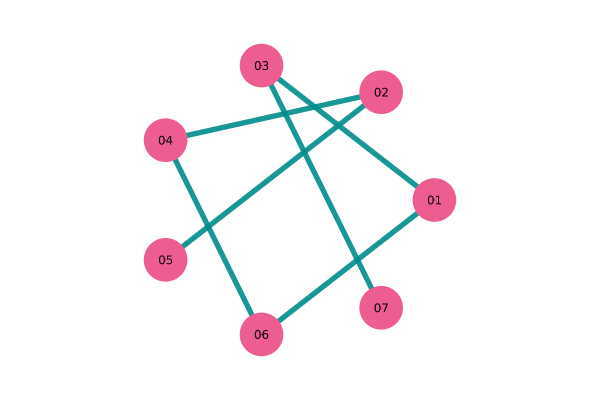

Weight: 0.26684874428403293


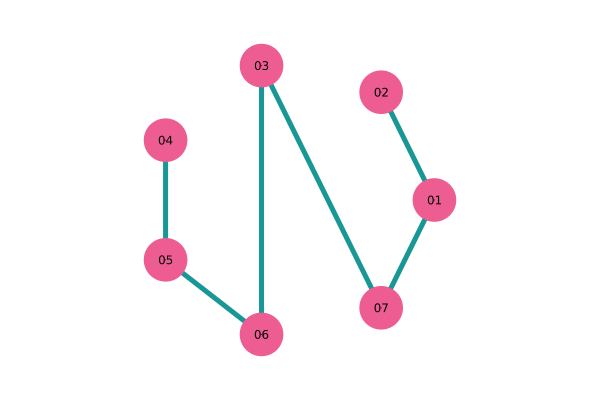

Weight: 0.252304916117812


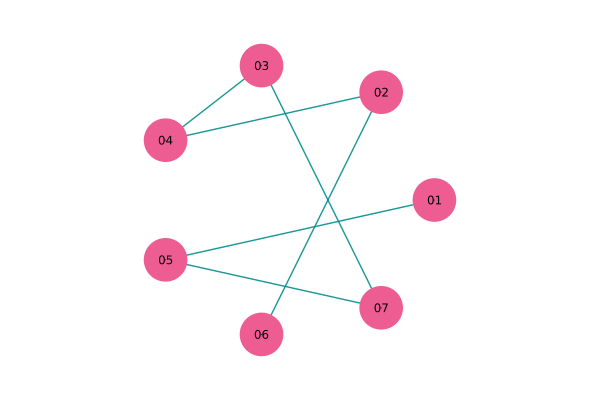

Weight: 0.07029192818157988


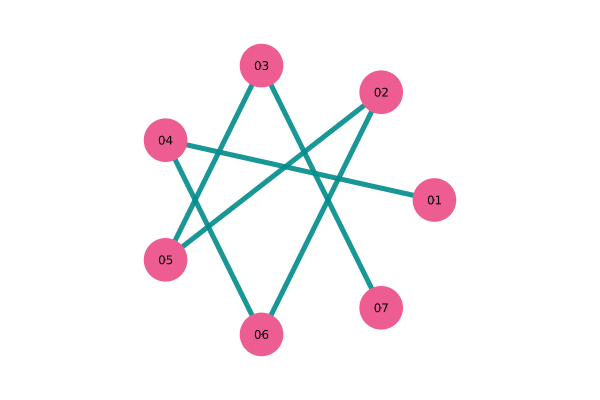

Weight: 0.25437426970067545


In [402]:
graph_mat_list = []

for (j,ord) in enumerate(tnqe3.ord_list)
    push!(graph_mat_list, GraphMat(ord, directed=false) )
end

for j=1:length(graph_mat_list)
    OrbitalGraphPlot(graph_mat_list[j], multiplier=20.0*abs(tnqe3.C[j,1]))
    println("Weight: ", abs(tnqe3.C[j,1]))
end


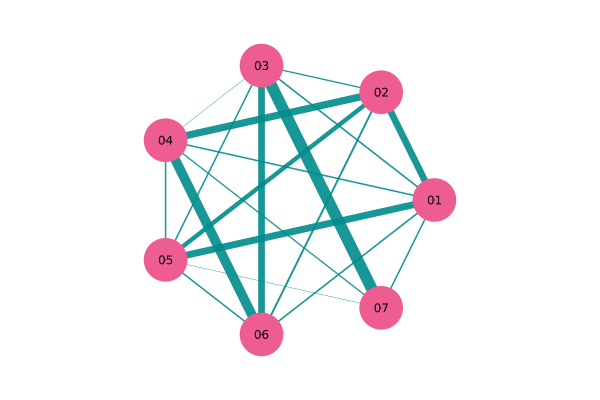

In [403]:
weight_list = abs.(tnqe3.C[:,1])

OrbitalGraphPlot(sum(graph_mat_list.*weight_list), multiplier=6.0)

In [404]:
randn(4)

4-element Vector{Float64}:
 -1.3709312619615945
 -1.1826789019923494
  0.05631551415666055
  1.035758888968531